# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 01.02.2022.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям **запрещено**, если это явно не прописано в условии.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов. 

In [1]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.ANTIALIAS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [2]:
size = 256
images = load_images("lfw-a.tgz", (size, size))

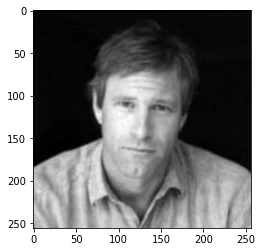

In [4]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [40]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

*В этом пункте (и только в этом) можно использовать цикл по изображениям.*

In [126]:
# каждому человеку соответствует массив фото. глобально фото --- nframes штук
# каждое фото из массива хотим записать в виде вектора (проход по столбцам). эти векторы будут столбцами M

M = []
for name in images.keys():
  for image in images[name]:
    image = image.reshape(size*size, order='F')  # изображение -> вектор
    M.append(image)  # в M i-я строка --- вектор i-й перебранной картинки
M = np.array(M).T  # теперь векторы записаны по столбцам

2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.
 
    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

Text(0, 0.5, 'Cингулярные числа')

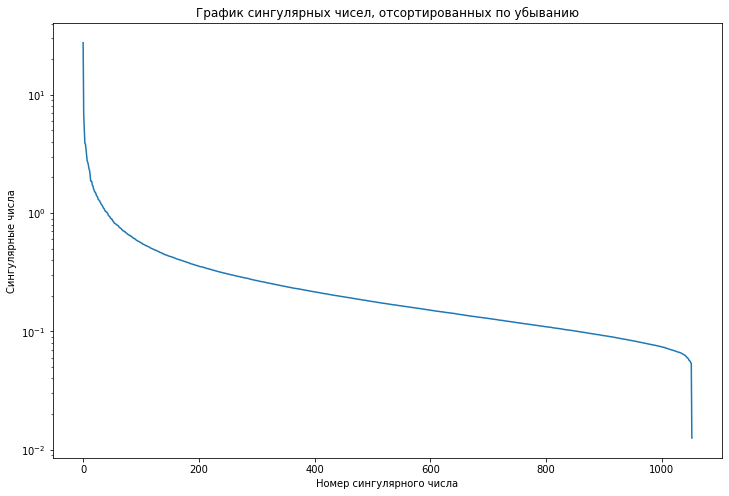

In [42]:
# вычисляем сингулярное разложение M
U, S, V = np.linalg.svd(M, full_matrices=False)

# в S хранится список сингулярных чисел, отсортированный по убыванию --- этот график и строим
plt.figure(figsize=(12,8))
plt.semilogy(S)

plt.title('График сингулярных чисел, отсортированных по убыванию')
plt.xlabel('Номер сингулярного числа')
plt.ylabel('Cингулярные числа')

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

In [10]:
def plot_as_images(mat, rows, cols):
    '''
        Visualize images from the columns of mat in a table of shape (rows, cols).

        Input
            mat: numpy array of shape (size * size, rows * cols)
            rows: number of rows in the table
            cols: number of columns in the table
    '''
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    for i in range(rows):
        for j in range(cols):
            # mat[:,i*cols + j] --- вектор-столбец, по очереди перебираем 0, 1, 2, ...
            # переделывам его в матрицу size * size --- изображение
            axes[i,j].imshow(mat[:,i*cols + j].reshape(size, size, order='F'), cmap="gray")
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)

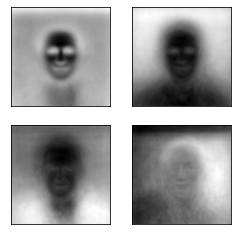

In [15]:
plot_as_images(U, 2, 2)  # в U лежат левые сингулярные векторы

In [53]:
# поменяю немного нулевой вектор, чтобы посмотреть, что изменится
U[:, 0] += 20 * U[0][0]

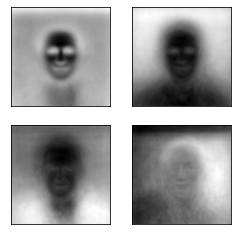

In [55]:
plot_as_images(U, 2, 2)

Кажется, что первое сингулярное число отвечает за контраст лица и фона.

In [61]:
# поменяю немного первый вектор (-> положение (0, 1)), чтобы посмотреть, что изменится
U[:, 1] += 20 * U[1][1]

In [62]:
U[:, 1]

array([38.10867037, 38.10868212, 38.10882051, ..., 38.10224382,
       38.10222742, 38.10223678])

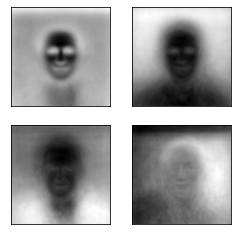

In [63]:
plot_as_images(U, 2, 2)

Кажется, что второе влияет на освещенность.

In [66]:
# поменяю немного второй вектор (-> положение (1, 1)), чтобы посмотреть, что изменится
U[:, 2] += 40 * U[2][1]

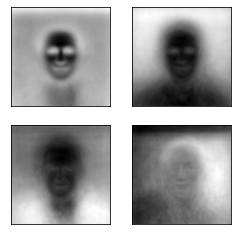

In [67]:
plot_as_images(U, 2, 2)

Кажется, что третье сингулярное число влияет на четкость.

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

*Как поняла задачу*: задан ранг массива M --- это r. Нужно найти оптимальное приближение этого массива M массивом ранга $\leq r$.

$\cdot$ Воспользуемся теоремой Эккарта-Янга-Мирковского: $\underset{B: \; rkB \leq k}{\min} ||A - B|| = ||A - A_k||$, где $A_k = U_k \Sigma_k V*_k$ --- усеченное SVD-разложение ($U_k$ --- первые k левых сингулярных векторов, $V_k$ --- правых, $\Sigma_k$ --- ведущая $k \times k$ подматрица $\Sigma$).

$\cdot$ Знаем из второй лекции, что $||A - A_k||_F = \sqrt{\sigma_{k + 1}^2(A) + ... + \sigma_r^2(A)}$. 

In [33]:
def trunc_svd(M, r):
    '''
        Input
            M: original 2D numpy array
            r: rank value for truncation
            
        Output
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            rel_eps: relative error of rank-r approximation Mr
    '''
    
    U, S, V = np.linalg.svd(M, full_matrices=False)
    U_r = U[:, :r]
    V_r = V[:r, :]  # SVD разложение дало нам V* => берем по строкам, чтобы получить столбцы
    S_r = S[:r]
    C_r = np.diag(S_r).dot(V_r)

    M_MR_norm = np.sqrt((S[(r + 1):]**2).sum())
    M_norm = np.linalg.norm(M)

    return U_r, C_r, M_MR_norm/M_norm

$\cdot$ Почему столбцы $U_r$ --- это ортонормированный базис $M_r$? $M_r = U_r S_r V_r = U_r (S_r V_r)$, т.е. $[m_r^1 m_r^2 ... m_r^n] = [u_r^1 ... u_r^r] [sv_r^1 ... sv_r^r]^T$, т.е $m_r^i$ --- линейная комбинация $u_r^j$. По определению SVD столбцы $U_r$ ортонормированы. Поэтому столбцы $U_r$ действительно будут ортонормальным базисом столбцов $M_r$.

5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [100]:
def plot_as_combination(M, U, C, count, indices):
    '''
        Input
            M: original 2D numpy array
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            count: desired number of images of singular vectors
            indices: indices of columns of M which are visualized
    '''

    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 2, len(indices)*2))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]
  
        axes[0].imshow(M[:, index].reshape(size, size, order="F"), cmap="gray") # Original image
        axes[0].set_xlabel("Orig")

        appr = U @ C[:, index]
        axes[1].imshow(appr.reshape(size, size, order="F"), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for i in range(count):
            axes[2 + i].imshow(U[:, i].reshape(size, size, order="F"), cmap="gray") # i-th singular vector image
            axes[2 + i].set_xlabel("{:.7}".format(C[i, index]))
        
        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

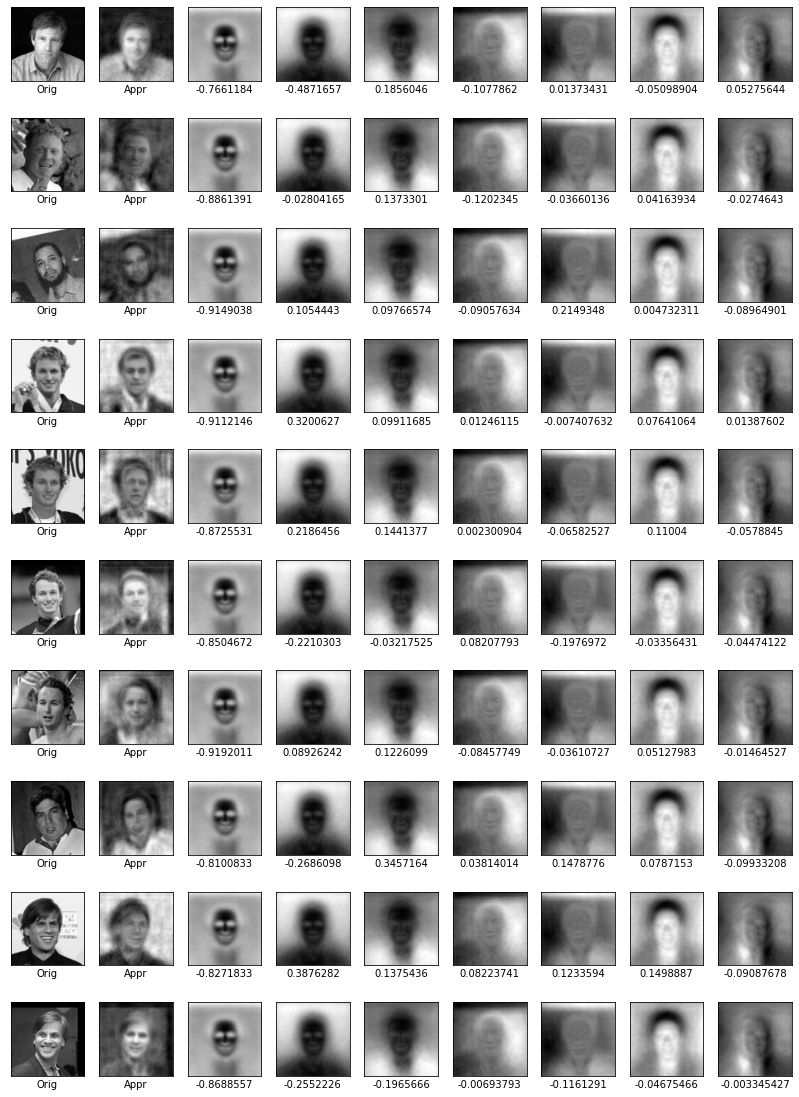

In [101]:
U, C, eps = trunc_svd(M, 100)
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

Алгоритм из лекции для матрицы A:

1. $\Omega = [w_1 ... w_r] \in \mathbb{R}^{n \times r}$ из $N(0, 1)$, где $r = k + p$.

2. $Y = A\Omega$

3. $QR = Y$

$B = Q(Q^*A) = Q(U\Sigma V^*)V = (QU)\Sigma V^*$

В $\Sigma$ оставить только первые k сингулярных чисел.

In [114]:
def rand_svd(M, r, p=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    
    W = np.random.randn(M.shape[1], r + p)
    Y = M.dot(W)
    Q, R = np.linalg.qr(Y)
    
    U, S, V = np.linalg.svd(Q.T.dot(M), full_matrices=False)
    U = U[:, :r]
    S = S[:r]
    V = V[:r, :]

    Mr = (Q.dot(U)).dot(np.diag(S)).dot(V)
    M_Mr_norm = np.linalg.norm(M - Mr)  # можно посчитать через сингулярные числа, как делали выше
    M_norm = np.linalg.norm(M)
    rel_err = M_Mr_norm/M_norm

    return Mr, rel_err

2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

In [121]:
r = 50
rand_svds = [0 for _ in range(21)]
M_norm = np.linalg.norm(M)

for _ in range(10):
  for p in range(0, 101, 5):
    _, rel_err = rand_svd(M, r, p)
    rel_err *= M_norm  # т.к. rel_err --- относительная ошибка, а мы хотим абсолютную
    rand_svds[p//5] += rel_err/10  # чтобы в итоге было среднее по 10 результатам

U, S, V = np.linalg.svd(M, full_matrices=False)
SVD_err = np.linalg.norm(U.dot(np.diag(S)).dot(V))
rand_svds = np.array(rand_svds)/SVD_err - 1

Text(0, 0.5, 'Относительная разница ошибок')

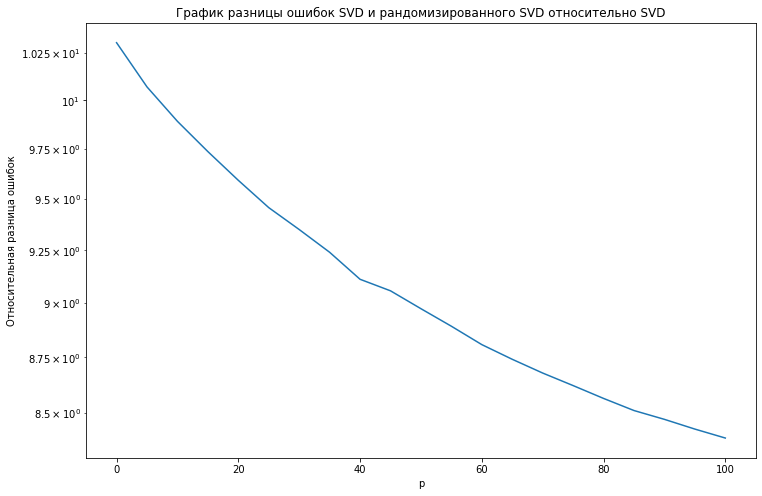

In [122]:
plt.figure(figsize=(12,8))
plt.yscale("log")

plt.plot(range(0, 101, 5), rand_svds)
plt.title('График разницы ошибок SVD и рандомизированного SVD относительно SVD')
plt.xlabel('p')
plt.ylabel('Относительная разница ошибок')

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [123]:
%timeit(rand_svd(M, 50))
%timeit(trunc_svd(M, 50))

1 loop, best of 5: 3.41 s per loop
1 loop, best of 5: 27.5 s per loop


Получается, в 27.5/3.41 = 8,06 раз.

### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [35]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [97]:
def get_closest_naive(M, new_v, count):
    """
        Input
            M: matrix of vectorized images
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list of count indices of closest images
    """
    # в M изображения записаны по столбцам
    M_dist = np.linalg.norm((M.T - new_v).T, axis=0)
    return np.argsort(M_dist)[:count]

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

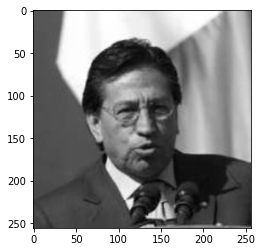

In [130]:
new = test_image
_ = plt.imshow(new, cmap="gray")

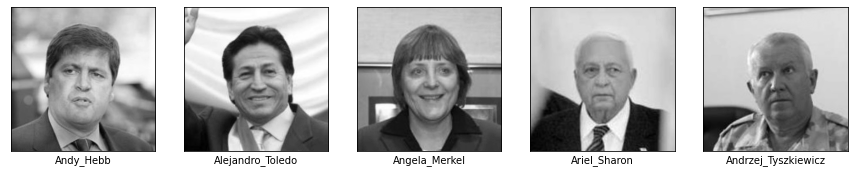

In [131]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [147]:
def get_closest_proj(U, C, new_v, count):
    """
        Input
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images
            
        Output
            indices: list (of len `count`) of indices of closest images
    """
    proj_v = U.T.dot(new_v)  # проецируем. остальные векторы уже спроецированы, 
    # т.к. U --- базис пространства столбцов

    # зануляем первую координату
    proj_v[0] = 0
    C[0, :] = 0 

    return get_closest_naive(C, proj_v, count)

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

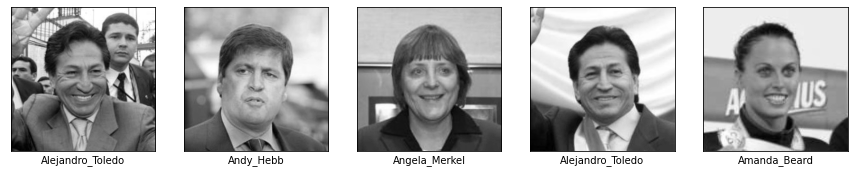

In [148]:
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.